## A

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from time import time

In [11]:
df = pd.read_csv('data/house_prices.csv')

In [12]:
df

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,parking,price
0,7420,4,2,3,1,0,0,2,791000
1,8960,4,4,4,1,0,0,3,919000
2,9960,3,2,2,1,0,1,2,994000
3,7500,4,2,2,1,0,1,3,811000
4,7420,4,1,2,1,1,1,2,801000
...,...,...,...,...,...,...,...,...,...
540,3000,2,1,1,1,0,1,2,474000
541,2400,3,1,1,0,0,0,0,373000
542,3620,2,1,1,1,0,0,0,471000
543,2910,3,1,1,0,0,0,0,402000


In [13]:
Y = df['price']
X = df.drop(columns=['price'])

In [14]:
scalerX = StandardScaler()
scalerY = StandardScaler()
X_std = scalerX.fit_transform(X)
Y = np.array(Y)
Y = Y.reshape((-1,1))
Y_std = scalerY.fit_transform(Y)

## B

In [16]:
def MSE(y_pred, y_true):
    return np.mean((y_true-y_pred)**2)/2

In [17]:
def batch_gradient_descent_linear_reggression(data, target, learning_rate, epochs):
    def prediction_calc(data, weights, bias):
        pred = np.zeros(shape=(len(data),1))
        for index, d in enumerate(data):
            for i in range(len(d)):
                pred[index, 0] += d[i]*weights[i]
            pred[index, 0] += bias
        return pred
        
    n_sample = data.shape[0]
    weights = np.zeros(shape=(data.shape[-1],1))
    bias = 0
    hist = []

    for epoch in tqdm(range(epochs), desc="Training Process"):
        prediction = prediction_calc(data, weights, bias)
        loss = MSE(prediction, target)
        weights -= learning_rate * (np.sum((prediction - target) * data, axis=0)/n_sample).reshape((-1,1))
        bias -= learning_rate * (np.sum((prediction - target), axis=0)/n_sample)
        hist.append(loss)
    return weights, bias, hist

In [18]:
selected_epochs = 50

In [19]:
BG_weights, BG_bias, BG_hist = batch_gradient_descent_linear_reggression(X_std, Y_std, 0.1, epochs=selected_epochs)

Training Process:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\mykar\AppData\Local\Temp\ipykernel_12472\968223071.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred[index, 0] += d[i]*weights[i]
C:\Users\mykar\AppData\Local\Temp\ipykernel_12472\968223071.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred[index, 0] += bias
Training Process: 100%|██████████| 50/50 [00:00<00:00, 92.84it/s]


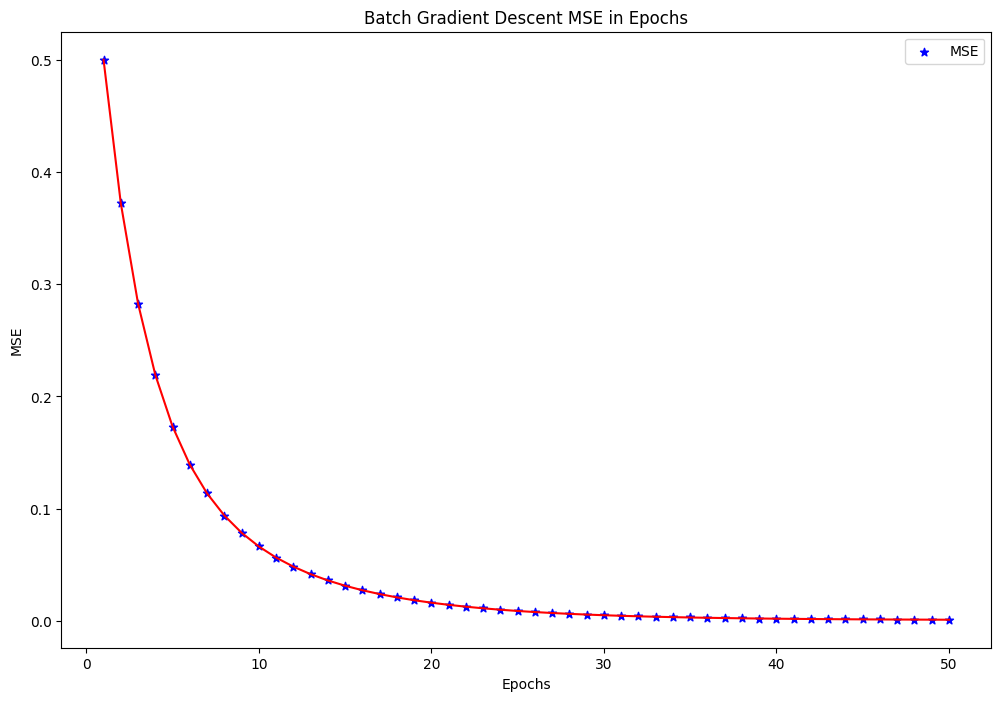

In [20]:
epochs = np.arange(1, len(BG_hist)+1)
plt.figure(figsize=(12, 8))
plt.scatter(epochs, BG_hist, color='blue', marker='*', label='MSE')
plt.plot(epochs, BG_hist, color='red', linestyle='-')
plt.title('Batch Gradient Descent MSE in Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

## C

In [21]:
all_predicted_std = np.dot(X_std, BG_weights)+BG_bias
all_predicted = scalerY.inverse_transform(all_predicted_std)
prices = pd.DataFrame(data = {'Real':Y.reshape(-1), 'Predicted': all_predicted.astype(int).reshape(-1)})
prices['Diff'] = np.abs(prices.iloc[:,0] - prices.iloc[:,1]).astype(int)
prices

,Real,Predicted,Diff
0,791000,788725,2275
1,919000,922106,3106
2,994000,981942,12058
3,811000,821724,10724
4,801000,810016,9016
...,...,...,...
540,474000,476318,2318
541,373000,374753,1753
542,471000,476411,5411
543,402000,410858,8858


In [22]:
sample = np.array([[7700, 3, 2, 1, 1, 0, 0, 2]])
sample_std = scalerX.transform(sample)
predicted_price_std = np.dot(sample_std, BG_weights)+BG_bias
predicted_price = scalerY.inverse_transform(predicted_price_std)
print(f'Predicted price for this house is {int(predicted_price.item())} But the sell price is 950000.')

Predicted price for this house is 793858 But the sell price is 950000.


c:\Users\mykar\Anaconda3\envs\anaconda-env\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


As you can see, the difference between the price that is predicted for a house, which is 793858, and the sell price, which is 950000, is so much lower. So this price is so much higher than its original price.

## D

In [28]:
def mini_batch_gradient_descent_linear_reggression(data, target,batch_size, learning_rate, epochs):
    def prediction_calc(data, weights, bias):
        pred = np.zeros(shape=(len(data),1))
        for index, d in enumerate(data):
            for i in range(len(d)):
                pred[index, 0] += d[i]*weights[i]
            pred[index, 0] += bias
        return pred    
    n_sample = data.shape[0]
    weights = np.zeros(shape=(data.shape[-1],1))
    bias = 0
    hist = []

    for epoch in tqdm(range(epochs)):
        permutation = np.random.permutation(n_sample)
        X_shuffle = data[permutation]
        Y_shuffle = target[permutation]
        for batch in range(0,n_sample, batch_size):
            data_batch = X_shuffle[batch:batch+batch_size]
            target_batch = Y_shuffle[batch:batch+batch_size]
            prediction = prediction_calc(data_batch, weights, bias)
            all_prediction = np.dot(data, weights) + bias
            hist.append(MSE(all_prediction, target))
            weights -= learning_rate * (np.sum((prediction - target_batch) * data_batch, axis=0)/batch_size).reshape((-1,1))
            bias -= learning_rate * (np.sum((prediction - target_batch), axis=0)/batch_size)
    return weights, bias, hist

In [29]:
def stochastic_gradient_descent_linear_reggression(data, target, learning_rate, epochs):
    def prediction_calc(data, weights, bias):
        pred = 0
        for i in range(len(data)):
            pred += data[i]*weights[i]
        pred += bias
        return pred  
    n_sample = data.shape[0]
    weights = np.zeros(shape=(data.shape[-1],1))
    bias = 0
    hist = []

    for epoch in tqdm(range(epochs), desc="Training Process"):
        permutation = np.random.permutation(n_sample)
        X_shuffle = data[permutation]
        Y_shuffle = target[permutation]
        for index in range(0,n_sample):
            prediction = prediction_calc(X_shuffle[index], weights, bias)
            weights -= learning_rate * (np.sum((prediction - Y_shuffle[index]) * X_shuffle[index], axis=0)).reshape((-1,1))
            bias -= learning_rate * (np.sum((prediction - Y_shuffle[index]), axis=0))
            all_prediction = np.dot(data, weights) + bias
            hist.append(MSE(all_prediction, target))
    return weights, bias, hist

In [30]:
MBG_weights, MBG_bias, MBG_hist = mini_batch_gradient_descent_linear_reggression(X_std, Y_std, 64, 0.01, epochs=selected_epochs)

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\mykar\AppData\Local\Temp\ipykernel_12472\1981634237.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred[index, 0] += d[i]*weights[i]
C:\Users\mykar\AppData\Local\Temp\ipykernel_12472\1981634237.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred[index, 0] += bias
100%|██████████| 50/50 [00:00<00:00, 89.99it/s]


In [31]:
SGD_weights, SGD_bias, SGD_hist = stochastic_gradient_descent_linear_reggression(X_std, Y_std, 0.00001, epochs=50)

Training Process: 100%|██████████| 50/50 [00:00<00:00, 56.56it/s]


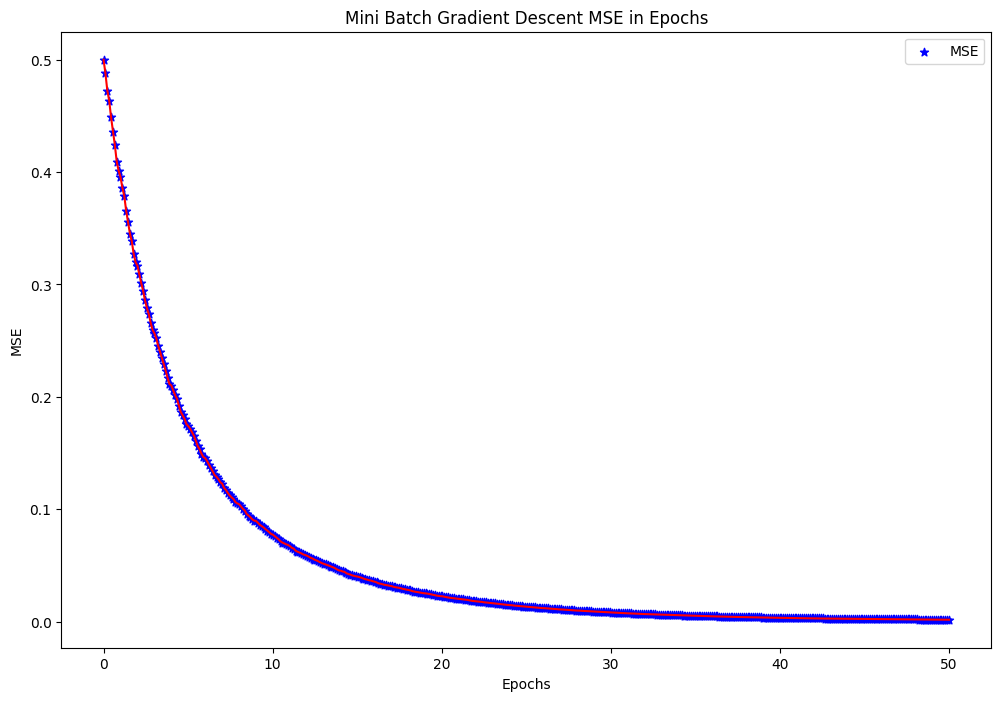

In [32]:
epochs = np.linspace(0, selected_epochs, len(MBG_hist))
plt.figure(figsize=(12, 8))
plt.scatter(epochs, MBG_hist, color='blue', marker='*', label='MSE')
plt.plot(epochs, MBG_hist, color='red', linestyle='-')
plt.title('Mini Batch Gradient Descent MSE in Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

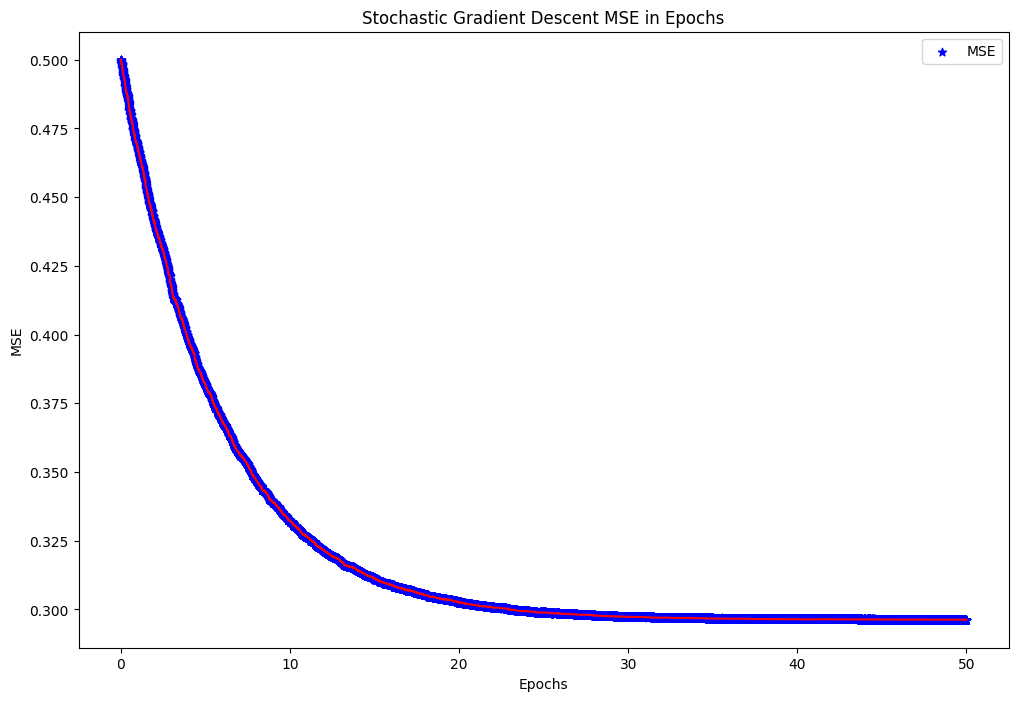

In [33]:
epochs = np.linspace(0, selected_epochs, len(SGD_hist))
plt.figure(figsize=(12, 8))
plt.scatter(epochs, SGD_hist, color='blue', marker='*', label='MSE')
plt.plot(epochs, SGD_hist, color='red', linestyle='-')
plt.title('Stochastic Gradient Descent MSE in Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

SGD has noise but because of high density it is not obvious in the above plot.

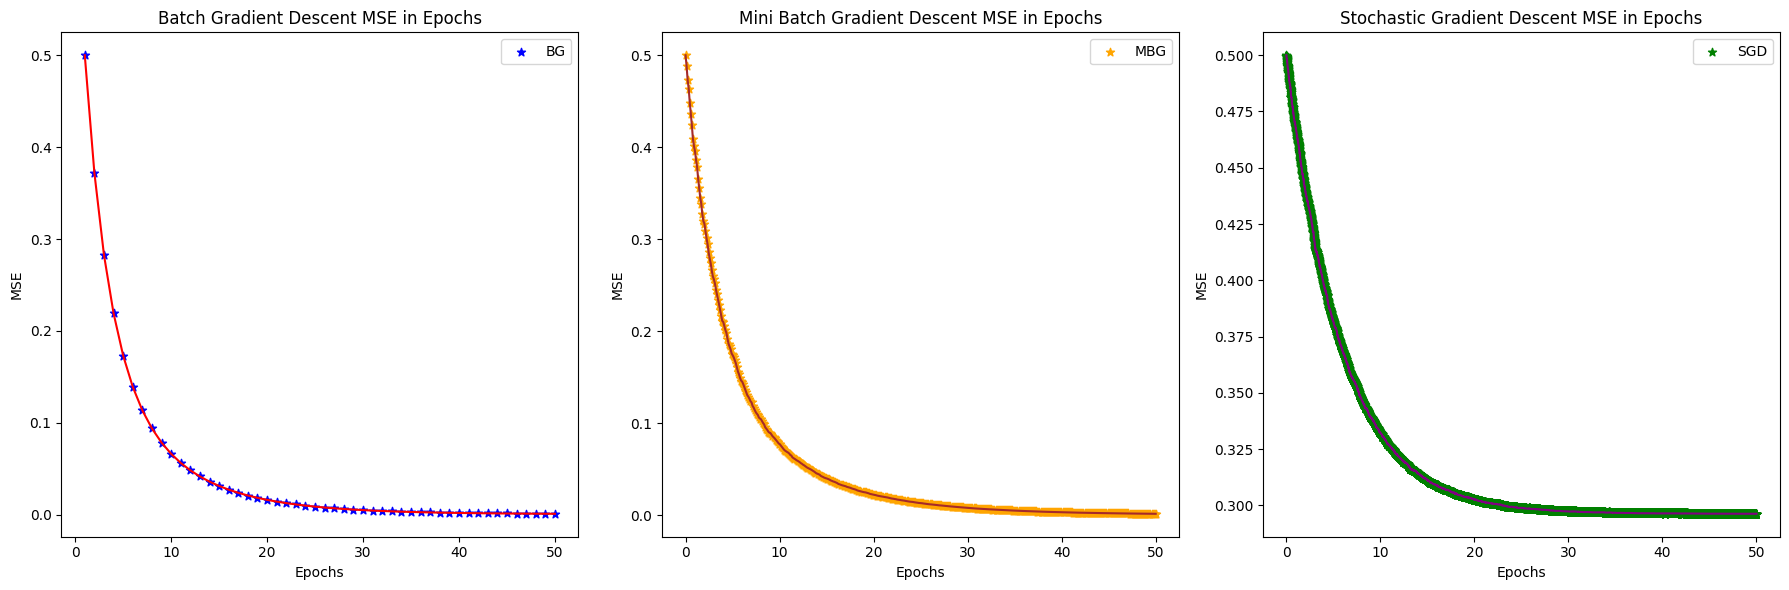

In [34]:
BG_steps = np.arange(1, len(BG_hist)+1)
SGD_steps = np.linspace(0, selected_epochs, len(SGD_hist))
MBG_steps = np.linspace(0, selected_epochs, len(MBG_hist))


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

axes[0].scatter(BG_steps, BG_hist, color='blue', marker='*', label='BG')
axes[0].plot(BG_steps, BG_hist, color='red', linestyle='-')
axes[0].set_title('Batch Gradient Descent MSE in Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('MSE')
axes[0].legend()

axes[1].scatter(MBG_steps, MBG_hist, color='orange', marker='*', label='MBG')
axes[1].plot(MBG_steps, MBG_hist, color='brown', linestyle='-')
axes[1].set_title('Mini Batch Gradient Descent MSE in Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('MSE')
axes[1].legend()

axes[2].scatter(SGD_steps, SGD_hist, color='green', marker='*', label='SGD')
axes[2].plot(SGD_steps, SGD_hist, color='purple', linestyle='-')
axes[2].set_title('Stochastic Gradient Descent MSE in Epochs')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('MSE')
axes[2].legend()

plt.tight_layout() 
plt.show()


In [35]:
Y_predicted_std = np.dot(X_std, BG_weights)+BG_bias
print(f'MSE on BG = {MSE(Y_predicted_std, Y_std)}')

Y_predicted_std = np.dot(X_std, MBG_weights)+MBG_bias
print(f'MSE on MBG = {MSE(Y_predicted_std, Y_std)}')

Y_predicted_std = np.dot(X_std, SGD_weights)+SGD_bias
print(f'MSE on SGD = {MSE(Y_predicted_std, Y_std)}')

MSE on BG = 0.000970027140783684
MSE on MBG = 0.0015921873921479705
MSE on SGD = 0.296281982968524


As you can see, batch gradient descent takes a long time to converge to a point with MSE = 0.000970027140783684, and mini-batch gradient descent takes a short time to converge to a point with MSE = 0.0015921873921479705, but in stochastic gradient descent it takes only a few epochs to converge to a point with MSE = 0.296281982968524 (but because MBG can use vectorization(that we do not use in this example) and not all the data(vectorization for all the data most of the times is not possible due to the large size of data) in every step, it the fastest).
So every step in SGD is faster than MBGD, and every step in MBGD is faster than BGD.
But BGD converges to a point that has the least error, and MBGD converges to a point that has a lower error than SGD.

Final results: <br>
Better based on time: SGD > MBGD > BGD <br>
Better based on error: BGD > MBGD > SGD

This is because when we have all the data, we converge to a point with lower variation, but when we use batch, we are optimizing based on a few data points, and when we have variation, it becomes more error-prone. but because we are using less data for optimization, we can do it much faster. For example, when we are using SGD in an epoch, we have to update the parameter number of the sample times, while when we are using BGD, we update parameters only once. So when we are using batches with a small size, we have more speed to converge, but then accuracy becomes a bit worse.

## E

Training Process:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\mykar\AppData\Local\Temp\ipykernel_12472\968223071.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred[index, 0] += d[i]*weights[i]
C:\Users\mykar\AppData\Local\Temp\ipykernel_12472\968223071.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred[index, 0] += bias
Training Process:   0%|          | 0/50 [00:00<?, ?it/s]c:\Users\mykar\Anaconda3\envs\anaconda-env\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\mykar\AppData\Local\Temp\ipykernel_12472\19397

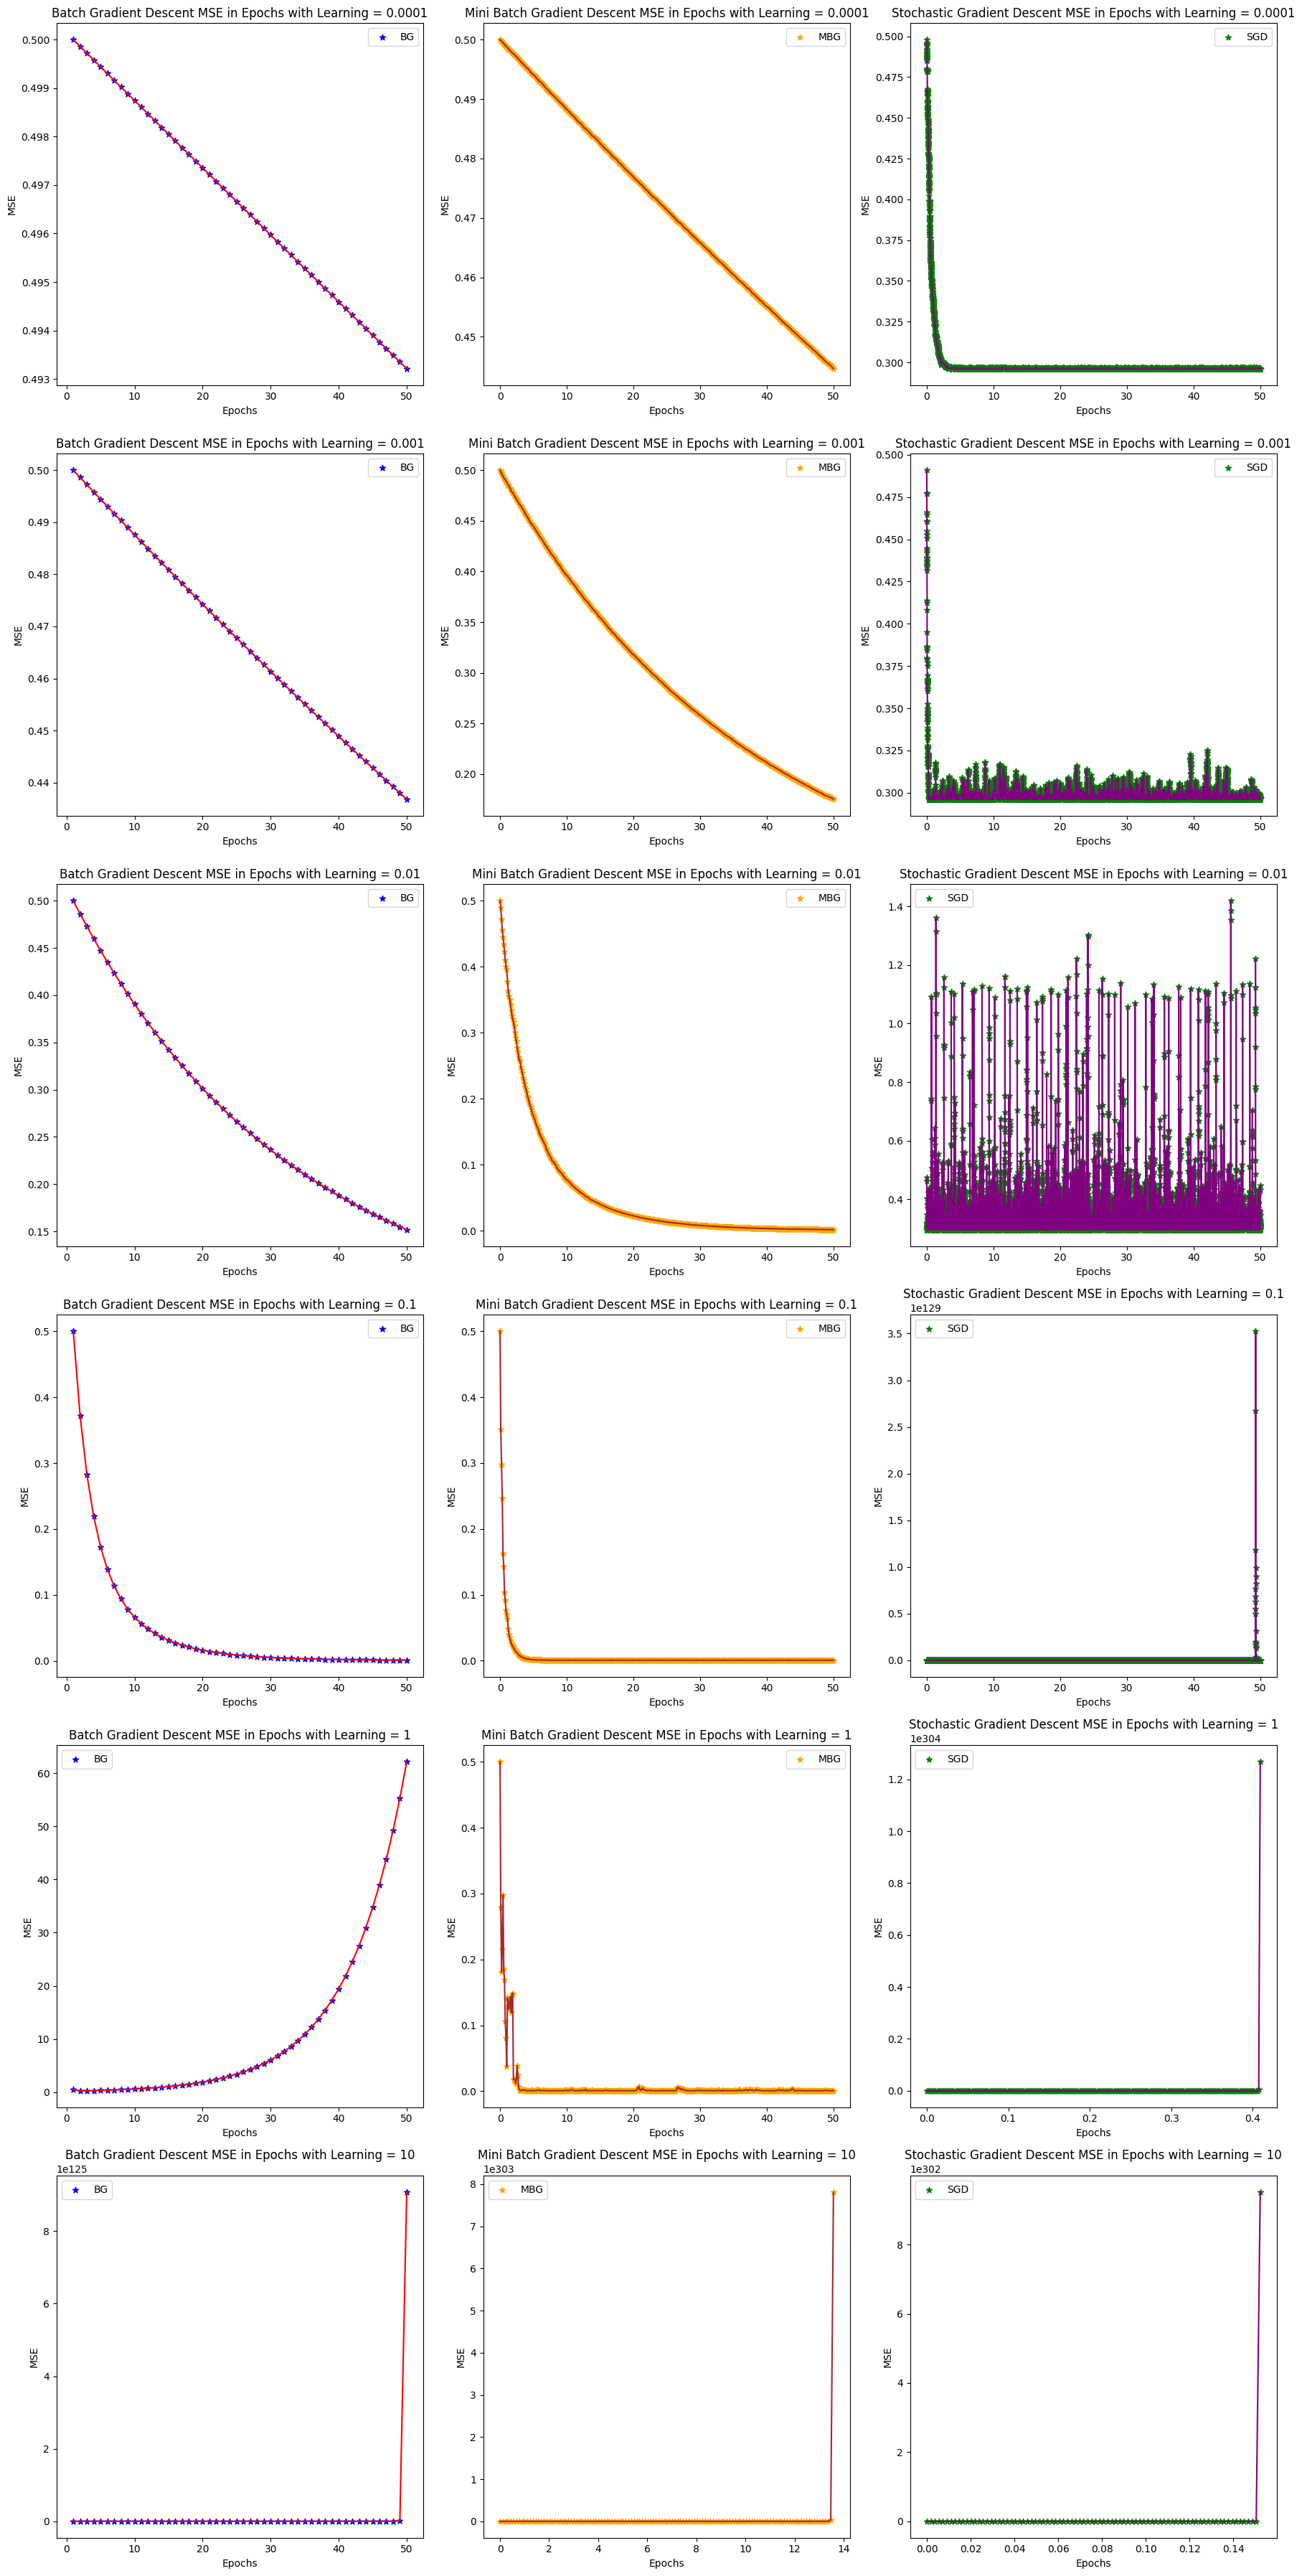

In [36]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1, 10]
epoch = selected_epochs
batch_size = 64

BG_steps = np.arange(1, len(BG_hist)+1)
SGD_steps = np.linspace(0, selected_epochs, len(SGD_hist))
MBG_steps = np.linspace(0, selected_epochs, len(MBG_hist))

fig, axes = plt.subplots(nrows=len(learning_rates), ncols=3, figsize = (18,6*len(learning_rates)))

for index,lr in enumerate(learning_rates):

    BG_weights, BG_bias, BG_hist = batch_gradient_descent_linear_reggression(X_std, Y_std, lr, epochs=epoch)
    MBG_weights, MBG_bias, MBG_hist = mini_batch_gradient_descent_linear_reggression(X_std, Y_std, batch_size, lr, epochs=epoch)
    SGD_weights, SGD_bias, SGD_hist = stochastic_gradient_descent_linear_reggression(X_std, Y_std, lr, epochs=epoch)
    
    axes[index,0].scatter(BG_steps, BG_hist, color='blue', marker='*', label='BG')
    axes[index,0].plot(BG_steps, BG_hist, color='red', linestyle='-')
    axes[index,0].set_title(f'Batch Gradient Descent MSE in Epochs with Learning = {lr}')
    axes[index,0].set_xlabel('Epochs')
    axes[index,0].set_ylabel('MSE')
    axes[index,0].legend()

    axes[index,1].scatter(MBG_steps, MBG_hist, color='orange', marker='*', label='MBG')
    axes[index,1].plot(MBG_steps, MBG_hist, color='brown', linestyle='-')
    axes[index,1].set_title(f'Mini Batch Gradient Descent MSE in Epochs with Learning = {lr}')
    axes[index,1].set_xlabel('Epochs')
    axes[index,1].set_ylabel('MSE')
    axes[index,1].legend()

    axes[index,2].scatter(SGD_steps, SGD_hist, color='green', marker='*', label='SGD')
    axes[index,2].plot(SGD_steps, SGD_hist, color='purple', linestyle='-')
    axes[index,2].set_title(f'Stochastic Gradient Descent MSE in Epochs with Learning = {lr}')
    axes[index,2].set_xlabel('Epochs')
    axes[index,2].set_ylabel('MSE')
    axes[index,2].legend()

plt.tight_layout() 
plt.show()


As you can see above, as Alpha becomes bigger, we converge faster, but if it becomes very big, we do not optimize at all but also have a higher cost and go further from the optimal point instead of getting close to it.

## F

In [37]:
start = time()
sklearn_reg = LinearRegression().fit(X_std, Y_std)
end = time()
sklearn_reg_time = end - start
print(f'Built in Sklearn LinearRegression takes {sklearn_reg_time}')
print(f'MSE = {MSE(sklearn_reg.predict(X_std), Y_std)}')

Built in Sklearn LinearRegression takes 0.008122920989990234
MSE = 0.000596111457256806


In [38]:
start = time()
BG_weights, BG_bias, hist = batch_gradient_descent_linear_reggression(X_std, Y_std, learning_rate = 0.1, epochs=selected_epochs)
end = time()
BG_time = end - start

Y_predicted_std = np.dot(X_std, BG_weights)+BG_bias
print(f'BG takes {BG_time}')
print(f'MSE = {MSE(Y_predicted_std, Y_std)}')

Training Process:   0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\mykar\AppData\Local\Temp\ipykernel_12472\968223071.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred[index, 0] += d[i]*weights[i]
C:\Users\mykar\AppData\Local\Temp\ipykernel_12472\968223071.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred[index, 0] += bias
Training Process: 100%|██████████| 50/50 [00:00<00:00, 94.01it/s]

BG takes 0.5338358879089355
MSE = 0.000970027140783684


As you can see, LinearRegression in SKlearn is so much better in terms of run time and a bit better in terms of MSE.

